In [1]:
import pickle as pkl
from scipy.special import softmax
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from vla_calibration.utils import *
from vla_calibration.calibration import *

plt.style.use('seaborn-v0_8')
pal = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
def run_experiment(
        task_name, 
        quant=None,
        alternate_set=1, 
        n_prompts=20, 
        n_cal_bins=12,
):
    
    data_save_dir = f"../results/libero_{task_name}"
    if quant is not None:
        data_save_dir += f"/{quant}"

    top_n_steps=1

    base_probs, _, correct = get_base_data(data_save_dir, top_n_steps)

    base_probs = np.expand_dims(base_probs, axis=2)

    all_probs = []

    for i in range(n_prompts):

        prompt_probs = []

        if alternate_set == 1:
            data_save_str = f"{data_save_dir}/episode_data_prompt_{i}.pkl"
        elif alternate_set == 2:
            data_save_str = f"{data_save_dir}/episode_data_prompt_{i}_v2.pkl"
        elif alternate_set == 3:
            data_save_str = f"{data_save_dir}/episode_data_prompt_{i}_v3.pkl"
        else:
            raise ValueError

        with open(data_save_str, "rb") as f:  
            data = pkl.load(f)

        for episode in data:

            episode_probs = []

            steps = episode["steps"]

            for step in steps[:top_n_steps]:

                logits = step["logits"]
                probs = softmax(logits, -1)

                episode_probs.append(probs)

            episode_probs = np.stack(episode_probs)
            prompt_probs.append(episode_probs)

        prompt_probs = np.stack(prompt_probs)

        all_probs.append(prompt_probs)

    
    all_probs = np.stack(all_probs)
    ens_probs = np.transpose(all_probs, (1,2,0,3,4))

    base_probs = base_probs[:,0]
    ens_probs = ens_probs[:,0]


    base_probs = np.max(base_probs, -1)
    ens_probs = np.max(ens_probs, -1)

    base_conf = np.mean(base_probs, -2)
    ens_conf = np.mean(ens_probs, -2)

    mean_base_conf = np.mean(base_conf, -1)
    mean_ens_conf = np.mean(ens_conf, -1)

    base_ece1 = round(get_ece(mean_base_conf, correct, n_cal_bins, p=1), 3)
    ens_ece1 = round(get_ece(mean_ens_conf, correct, n_cal_bins, p=1), 3)

    base_ece2 = round(get_ece(mean_base_conf, correct, n_cal_bins, p=2), 3)
    ens_ece2 = round(get_ece(mean_ens_conf, correct, n_cal_bins, p=2), 3)

    base_brier = round(np.mean((mean_base_conf - correct)**2), 3)
    ens_brier = round(np.mean((mean_ens_conf - correct)**2), 3)

    base_ce = cross_entropy(correct, mean_base_conf)
    ens_ce = cross_entropy(correct, mean_ens_conf)

    if quant is not None:
        quant_tag = quant
    else:
        quant_tag = "Full"

    base_row = [task_name, quant_tag, "baseline", base_ece1, base_ece2, base_brier, base_ce, np.mean(correct)]
    ens_row = [task_name, quant_tag, "reprompt", ens_ece1, ens_ece2, ens_brier, ens_ce, np.mean(correct)]
    rows = [base_row, ens_row]

    df = pd.DataFrame(rows, columns=["Dataset","Model","Method","ECE-1","ECE-2","Brier","NLL","Accuracy"])
    return df
    


In [3]:
n_bins = 12
alternate_set = 1

full_df = pd.DataFrame()

In [4]:
for i in range(3):
    alternate_set = i+1

    df = run_experiment(
        "spatial", 
        alternate_set=alternate_set, 
        n_cal_bins=n_bins,
        n_prompts=20
    )
    df["Prompt"] = alternate_set
    full_df = pd.concat([full_df, df])

    display(full_df)

    df = run_experiment(
        "object", 
        alternate_set=alternate_set, 
        n_cal_bins=n_bins,
        n_prompts=20
    )
    df["Prompt"] = alternate_set
    full_df = pd.concat([full_df, df])

    display(full_df)

    df = run_experiment(
        "goal", 
        alternate_set=alternate_set,  
        n_cal_bins=n_bins,
        n_prompts=20
    )
    df["Prompt"] = alternate_set
    full_df = pd.concat([full_df, df])

    display(full_df)

,Dataset,Model,Method,ECE-1,ECE-2,Brier,NLL,Accuracy,Prompt
0,spatial,Full,baseline,0.088,0.106,0.150,0.533038,0.828,1
1,spatial,Full,reprompt,0.052,0.068,0.145,0.476606,0.828,1


,Dataset,Model,Method,ECE-1,ECE-2,Brier,NLL,Accuracy,Prompt
0,spatial,Full,baseline,0.088,0.106,0.150,0.533038,0.828,1
1,spatial,Full,reprompt,0.052,0.068,0.145,0.476606,0.828,1
0,object,Full,baseline,0.060,0.073,0.108,0.401004,0.880,1
1,object,Full,reprompt,0.036,0.053,0.105,0.360989,0.880,1


,Dataset,Model,Method,ECE-1,ECE-2,Brier,NLL,Accuracy,Prompt
0,spatial,Full,baseline,0.088,0.106,0.150,0.533038,0.828,1
1,spatial,Full,reprompt,0.052,0.068,0.145,0.476606,0.828,1
0,object,Full,baseline,0.060,0.073,0.108,0.401004,0.880,1
1,object,Full,reprompt,0.036,0.053,0.105,0.360989,0.880,1
0,goal,Full,baseline,0.151,0.170,0.207,0.707188,0.758,1
1,goal,Full,reprompt,0.115,0.132,0.197,0.619534,0.758,1


,Dataset,Model,Method,ECE-1,ECE-2,Brier,NLL,Accuracy,Prompt
0,spatial,Full,baseline,0.088,0.106,0.150,0.533038,0.828,1
1,spatial,Full,reprompt,0.052,0.068,0.145,0.476606,0.828,1
0,object,Full,baseline,0.060,0.073,0.108,0.401004,0.880,1
1,object,Full,reprompt,0.036,0.053,0.105,0.360989,0.880,1
0,goal,Full,baseline,0.151,0.170,0.207,0.707188,0.758,1
1,goal,Full,reprompt,0.115,0.132,0.197,0.619534,0.758,1
0,spatial,Full,baseline,0.088,0.106,0.150,0.533038,0.828,2
1,spatial,Full,reprompt,0.053,0.070,0.145,0.474424,0.828,2


,Dataset,Model,Method,ECE-1,ECE-2,Brier,NLL,Accuracy,Prompt
0,spatial,Full,baseline,0.088,0.106,0.150,0.533038,0.828,1
1,spatial,Full,reprompt,0.052,0.068,0.145,0.476606,0.828,1
0,object,Full,baseline,0.060,0.073,0.108,0.401004,0.880,1
1,object,Full,reprompt,0.036,0.053,0.105,0.360989,0.880,1
0,goal,Full,baseline,0.151,0.170,0.207,0.707188,0.758,1
1,goal,Full,reprompt,0.115,0.132,0.197,0.619534,0.758,1
0,spatial,Full,baseline,0.088,0.106,0.150,0.533038,0.828,2
1,spatial,Full,reprompt,0.053,0.070,0.145,0.474424,0.828,2
0,object,Full,baseline,0.060,0.073,0.108,0.401004,0.880,2
1,object,Full,reprompt,0.028,0.038,0.105,0.366053,0.880,2


,Dataset,Model,Method,ECE-1,ECE-2,Brier,NLL,Accuracy,Prompt
0,spatial,Full,baseline,0.088,0.106,0.150,0.533038,0.828,1
1,spatial,Full,reprompt,0.052,0.068,0.145,0.476606,0.828,1
0,object,Full,baseline,0.060,0.073,0.108,0.401004,0.880,1
1,object,Full,reprompt,0.036,0.053,0.105,0.360989,0.880,1
0,goal,Full,baseline,0.151,0.170,0.207,0.707188,0.758,1
1,goal,Full,reprompt,0.115,0.132,0.197,0.619534,0.758,1
0,spatial,Full,baseline,0.088,0.106,0.150,0.533038,0.828,2
1,spatial,Full,reprompt,0.053,0.070,0.145,0.474424,0.828,2
0,object,Full,baseline,0.060,0.073,0.108,0.401004,0.880,2
1,object,Full,reprompt,0.028,0.038,0.105,0.366053,0.880,2


,Dataset,Model,Method,ECE-1,ECE-2,Brier,NLL,Accuracy,Prompt
0,spatial,Full,baseline,0.088,0.106,0.150,0.533038,0.828,1
1,spatial,Full,reprompt,0.052,0.068,0.145,0.476606,0.828,1
0,object,Full,baseline,0.060,0.073,0.108,0.401004,0.880,1
1,object,Full,reprompt,0.036,0.053,0.105,0.360989,0.880,1
0,goal,Full,baseline,0.151,0.170,0.207,0.707188,0.758,1
1,goal,Full,reprompt,0.115,0.132,0.197,0.619534,0.758,1
0,spatial,Full,baseline,0.088,0.106,0.150,0.533038,0.828,2
1,spatial,Full,reprompt,0.053,0.070,0.145,0.474424,0.828,2
0,object,Full,baseline,0.060,0.073,0.108,0.401004,0.880,2
1,object,Full,reprompt,0.028,0.038,0.105,0.366053,0.880,2


,Dataset,Model,Method,ECE-1,ECE-2,Brier,NLL,Accuracy,Prompt
0,spatial,Full,baseline,0.088,0.106,0.150,0.533038,0.828,1
1,spatial,Full,reprompt,0.052,0.068,0.145,0.476606,0.828,1
0,object,Full,baseline,0.060,0.073,0.108,0.401004,0.880,1
1,object,Full,reprompt,0.036,0.053,0.105,0.360989,0.880,1
0,goal,Full,baseline,0.151,0.170,0.207,0.707188,0.758,1
1,goal,Full,reprompt,0.115,0.132,0.197,0.619534,0.758,1
0,spatial,Full,baseline,0.088,0.106,0.150,0.533038,0.828,2
1,spatial,Full,reprompt,0.053,0.070,0.145,0.474424,0.828,2
0,object,Full,baseline,0.060,0.073,0.108,0.401004,0.880,2
1,object,Full,reprompt,0.028,0.038,0.105,0.366053,0.880,2


,Dataset,Model,Method,ECE-1,ECE-2,Brier,NLL,Accuracy,Prompt
0,spatial,Full,baseline,0.088,0.106,0.150,0.533038,0.828,1
1,spatial,Full,reprompt,0.052,0.068,0.145,0.476606,0.828,1
0,object,Full,baseline,0.060,0.073,0.108,0.401004,0.880,1
1,object,Full,reprompt,0.036,0.053,0.105,0.360989,0.880,1
0,goal,Full,baseline,0.151,0.170,0.207,0.707188,0.758,1
1,goal,Full,reprompt,0.115,0.132,0.197,0.619534,0.758,1
0,spatial,Full,baseline,0.088,0.106,0.150,0.533038,0.828,2
1,spatial,Full,reprompt,0.053,0.070,0.145,0.474424,0.828,2
0,object,Full,baseline,0.060,0.073,0.108,0.401004,0.880,2
1,object,Full,reprompt,0.028,0.038,0.105,0.366053,0.880,2


In [5]:
df = full_df.sort_values(["Dataset", "Prompt", "Method"]).drop_duplicates(['Dataset', 'Model', 'Method', 'ECE-1', 'ECE-2', 'Brier', 'NLL',
       'Accuracy'])[['Dataset', 'Method', 'Prompt', 'ECE-1', 'ECE-2', 'NLL', 'Brier']]
df

,Dataset,Method,Prompt,ECE-1,ECE-2,NLL,Brier
0,goal,baseline,1,0.151,0.170,0.707188,0.207
1,goal,reprompt,1,0.115,0.132,0.619534,0.197
1,goal,reprompt,2,0.117,0.137,0.620639,0.197
1,goal,reprompt,3,0.127,0.152,0.621012,0.197
0,object,baseline,1,0.060,0.073,0.401004,0.108
1,object,reprompt,1,0.036,0.053,0.360989,0.105
1,object,reprompt,2,0.028,0.038,0.366053,0.105
1,object,reprompt,3,0.036,0.048,0.360718,0.104
0,spatial,baseline,1,0.088,0.106,0.533038,0.150
1,spatial,reprompt,1,0.052,0.068,0.476606,0.145


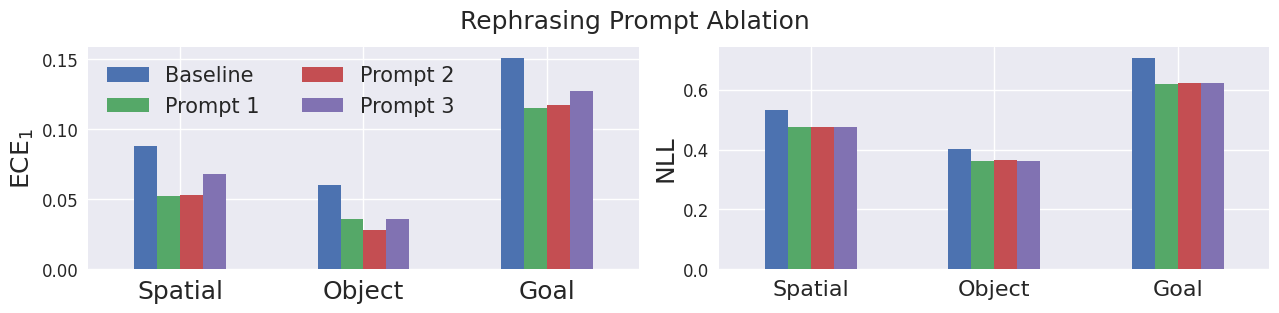

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(13, 3.25))

# # Pivot the data for plotting
pivot_df = df.pivot(index='Dataset', columns=['Method', 'Prompt'], values='ECE-1')

# Adjust the columns for clearer labels
pivot_df.columns = ['Baseline', 'Prompt 1', 'Prompt 2', 'Prompt 3']

# Define the desired dataset order
dataset_order = ["spatial", "object", "goal"]

# Reindex the pivoted DataFrame using the specified order
ordered_df = pivot_df.reindex(dataset_order)

# Plot the reordered DataFrame
ordered_df.plot(ax=axs[0], kind='bar')
axs[0].set_ylabel(r"$\text{ECE}_1$", fontsize=18)
axs[0].set_xlabel("")
# plt.title('Rephrasing Prompt Ablation', fontsize=16)
axs[0].set_xticks(np.arange(len(dataset_order)), [str.title(d) for d in dataset_order], rotation=0, fontsize=18)
axs[0].legend(loc='upper left', ncol=2, fontsize=15)


pivot_df = df.pivot(index='Dataset', columns=['Method', 'Prompt'], values='NLL')

# Adjust the columns for clearer labels
pivot_df.columns = ['Baseline', 'Prompt 1', 'Prompt 2', 'Prompt 3']

# Define the desired dataset order
dataset_order = ["spatial", "object", "goal"]

# Reindex the pivoted DataFrame using the specified order
ordered_df = pivot_df.reindex(dataset_order)

# Plot the reordered DataFrame
ordered_df.plot(ax=axs[1], kind='bar', legend=False)
axs[1].set_ylabel(r"NLL", fontsize=18)
axs[1].set_xlabel("")
# plt.title('Rephrasing Prompt Ablation', fontsize=16)
axs[1].set_xticks(np.arange(len(dataset_order)), [str.title(d) for d in dataset_order], rotation=0, fontsize=16)

for i in range(2):
    axs[i].tick_params(axis='y', labelsize=12)

fig.suptitle("Rephrasing Prompt Ablation", fontsize=18, y=0.95)


plt.tight_layout()
plt.savefig("../plots/rephrasings_ablation_both.png", dpi=600, bbox_inches="tight")
plt.show()
